Pre-Requisites for this notebook:
* Install Anaconda & install redshift_connector with conda
* Either launch Jupyter Notebook from Anaconda Navigator or install and setup VS Code with Python and Jupyter Extensions
* Connect to VPN
* Get your RedShift credentials

In [372]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import pandas as pd
import redshift_connector
from datetime import datetime, timedelta
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError

In [373]:
# Import user credentials from user_credentials.csv file
usr_cred = pd.read_csv('user_credentials.csv')
username = usr_cred.iloc[0]['Username']
passwd = usr_cred.iloc[0]['Password']
opnaikey = usr_cred.iloc[0]['OpenAI Key']

User credentials are entered onto a local csv file in the format shown below. ***Don't add your credentials to this file, or share your user credentials csv!***
| Username    | Password | OpenAI Key |
|-------------|----------|------------|
| rv-employee | 1234     | 567#       |

In [374]:
# Connect to RedShift and pull data
# Redshift connection details
host = 'dbops-redshift-cluster-apple.cd92olv6lp21.us-east-1.redshift.amazonaws.com'
port = '5439'
database = 'dev'
user = username # Use your username
password = passwd # Use your password

# Select Apple Card Query
card_query = """
select
eventdate,
sum(spend) as spend
from apple_reporting.applecard_paidsearch_view
where eventdate between '2023-12-31' and current_date - 1
and budgettype ilike 'Performance'
group by 1
order by 1 DESC;
"""
try:
    # Connect to Redshift
    conn = redshift_connector.connect(
        host = host,
        port = port,
        database = database,
        user = user,
        password = password
    )
    # Create a cursor
    cursor = conn.cursor()
    # Execute the select query
    cursor.execute(card_query)
    # Fetch all the results
    apple_card = cursor.fetchall()
    # Close the cursor and connection
    cursor.close()
    conn.close()
except redshift_connector.Error as e:
    print('Error connecting to Redshift:', e)

In [375]:
# Select Apple Gift Card Query
gc_query = """
select
eventdate,
sum(spend) as spend
from apple_reporting.applegiftcard_all_view
where eventdate between '2023-12-31' and current_date - 1
and vendor = 'Google'
group by 1
order by 1 DESC;
"""
try:
    # Connect to Redshift
    conn = redshift_connector.connect(
        host = host,
        port = port,
        database = database,
        user = user,
        password = password
    )
    # Create a cursor
    cursor = conn.cursor()
    # Execute the select query
    cursor.execute(gc_query)
    # Fetch all the results
    apple_gc = cursor.fetchall()
    # Close the cursor and connection
    cursor.close()
    conn.close()
except redshift_connector.Error as e:
    print('Error connecting to Redshift:', e)

In [376]:
# Store data in dataframe and add column names
df_card = pd.DataFrame(apple_card)
df_card.columns = ['Date', 'Spend']

df_gc = pd.DataFrame(apple_gc)
df_gc.columns = ['Date', 'Spend']

In [377]:
# Define some functions
def curr_form(amount):
    return "${:,.0f}".format(round(amount))

def percent_form(amount):
    return "{:.0%}".format(amount)

In [378]:
# Define your end date here (Year, Month, Day)
end_date = datetime(2024, 3, 30)
# Get the current date
current_date = datetime.now()
# Calculate the difference between the end date and the current date
days_remaining = (end_date - current_date).days + 2

In [379]:
# Card Pacing Variables
card_spend = float(df_card.sum())
card_budget = 2350427
card_yesteryday_spend = df_card['Spend'].iloc[0]
card_required_rr = float((card_budget - card_spend) / days_remaining)

# Initialize an empty string for the action message
card_action_message = ""

# Check if yesterday's spend is greater than the required run rate by more than 20%
if card_yesteryday_spend > card_required_rr * 1.2:
    card_action_message = "ACTION NEEDED: Decrease Card spend"
if card_yesteryday_spend < card_required_rr * .8:
    card_action_message = "ACTION NEEDED: Increase Card spend"

/var/folders/tj/sm7q99dx51xfb0hvfzwjlshr0000gq/T/ipykernel_53482/860806926.py:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  card_spend = float(df_card.sum())


In [380]:
# Gift Card Pacing Variables
gc_spend = float(df_gc.sum())
gc_budget = 36364
gc_yesteryday_spend = df_gc['Spend'].iloc[0]
gc_required_rr = float((gc_budget - gc_spend) / days_remaining)

# Initialize an empty string for the action message
gc_action_message = ""

# Check if yesterday's spend is greater than the required run rate by more than 20%
if gc_yesteryday_spend > gc_required_rr * 1.2:
    gc_action_message = "ACTION NEEDED: Decrease Gift Card spend"
if gc_yesteryday_spend < gc_required_rr * .8:
    gc_action_message = "ACTION NEEDED: Increase Gift Card spend"

/var/folders/tj/sm7q99dx51xfb0hvfzwjlshr0000gq/T/ipykernel_53482/3290390447.py:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  gc_spend = float(df_gc.sum())


In [381]:
pacing_update = "Card: We have spent {} so far this quarter with a {} daily RR required to spend in full. We spent {} yesterday.\n{}\n\nGift Card: We have spent {} so far this quarter with a {} daily RR required to spend in full. We spent {} yesterday.\n{}".format(\
    curr_form(card_spend), curr_form(card_required_rr), curr_form(card_yesteryday_spend), card_action_message, curr_form(gc_spend), curr_form(gc_required_rr), curr_form(gc_yesteryday_spend), gc_action_message) 

print(pacing_update)

Card: We have spent $1,673,206 so far this quarter with a $21,846 daily RR required to spend in full. We spent $24,772 yesterday.


Gift Card: We have spent $21,040 so far this quarter with a $494 daily RR required to spend in full. We spent $490 yesterday.



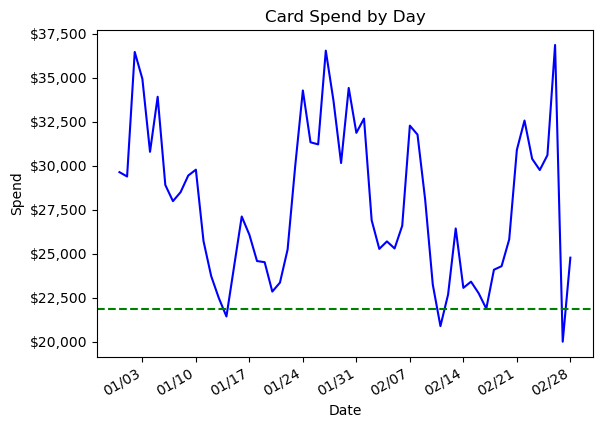

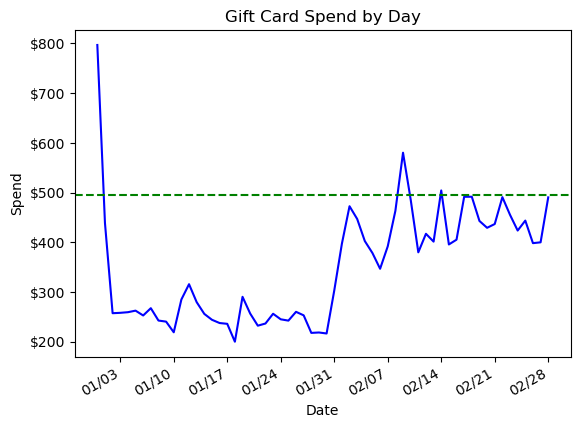

In [382]:
# CARD PACING CHART

# Set 'Date' column as the index
df_card.set_index('Date', inplace=True)

# Plot the 'Spend' column as a bar chart
df_card['Spend'].plot(kind='line', color='blue')

# Draw a green dotted line at the y-value of 'card_required_rr'
plt.axhline(y=card_required_rr, color='g', linestyle='--')

# Set the date format on x-axis as 'month/day'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# Set the x-axis ticks to appear every 7 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Rotate date labels to prevent overlap
plt.gcf().autofmt_xdate()

# Format y-axis labels with a dollar sign and a comma as the thousands separator
formatter = ticker.FuncFormatter(lambda x, p: '${:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

# Set the title for the chart
plt.title('Card Spend by Day')

# Set the label for the x-axis
plt.xlabel('Date')

# Set the label for the y-axis
plt.ylabel('Spend')

# Display the plot
plt.show()


# GIFT CARD PACING CHART

# Set 'Date' column as the index
df_gc.set_index('Date', inplace=True)

# Plot the 'Spend' column as a bar chart
df_gc['Spend'].plot(kind='line', color='blue')

# Draw a green dotted line at the y-value of 'card_required_rr'
plt.axhline(y=gc_required_rr, color='g', linestyle='--')

# Set the date format on x-axis as 'month/day'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# Set the x-axis ticks to appear every 7 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Rotate date labels to prevent overlap
plt.gcf().autofmt_xdate()

# Format y-axis labels with a dollar sign and a comma as the thousands separator
formatter = ticker.FuncFormatter(lambda x, p: '${:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

# Set the title for the chart
plt.title('Gift Card Spend by Day')

# Set the label for the x-axis
plt.xlabel('Date')

# Set the label for the y-axis
plt.ylabel('Spend')

# Display the plot
plt.show()